In [1]:
# from keras import Sequential
import pandas
import sklearn
from sklearn.model_selection import train_test_split

# from transformers import BertTokenizerFast, TFBertForSequenceClassification, TrainingArguments, Trainer

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

import numpy as np

tf.get_logger().setLevel('ERROR')


ImportError: Traceback (most recent call last):
  File "/home/islempenywis/.local/lib/python3.9/site-packages/tensorflow/python/pywrap_tensorflow.py", line 60, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: librccl.so.1: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

### Define Our Constants

In [2]:
DATASETS_PATH = "../data"
DATASET_FILE_NAME = "hate-speech-labeled.csv"
TEST_SIZE = 0.2
TRAIN_SIZE = 0.8
DATA_NEED_PREPROCESSING = False
SENTENCE_MAX_LENGTH = 512
TOKENIZER_MODEL_NAME = "bert-base-uncased"
NUM_OF_LABELS = 3

### Reading Dataset

In [3]:
loadedData = pandas.read_csv(DATASETS_PATH + "/" + DATASET_FILE_NAME)

loadedData.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


### Dataset Analysis

In [4]:
print("Total Size: ", len(loadedData))
print("Test Size: ", len(loadedData) * TEST_SIZE)
print("Train Size: ", len(loadedData) * TRAIN_SIZE)
print("Does the data set have any null values? ", loadedData.isnull().values.any())
print("Does the data set have any duplicate values? ", loadedData.duplicated().any())
print("Does the data have any missing values? ", loadedData.isna().values.any())
print("Does the data have offensive words? ", loadedData["offensive_language"].any())
print("Number of hate speech tweets: ", (loadedData["class"] == 0).sum())
print("Number of neutral tweets: ", (loadedData["class"] == 2).sum())
print("Number of offensive tweets: ", (loadedData["class"] == 1).sum())

Total Size:  24783
Test Size:  4956.6
Train Size:  19826.4
Does the data set have any null values?  False
Does the data set have any duplicate values?  False
Does the data have any missing values?  False
Does the data have offensive words?  True
Number of hate speech tweets:  1430
Number of neutral tweets:  4163
Number of offensive tweets:  19190


### Preprocessing Data
(Some data are already pre-processed)

In [98]:
##Preprocessing...
data = loadedData

tweetsText = data.tweet
tweetLabels = data['class']

tweetLabels = tf.keras.utils.to_categorical(tweetLabels.values, NUM_OF_LABELS)
tweetLabels
# tweetLabels = data['hate_speech']

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

### Splitting Data

In [101]:
(trainTexts, testTexts, trainLabels, testLabels) = train_test_split(tweetsText, tweetLabels, test_size=TEST_SIZE, train_size=TRAIN_SIZE)

# trainTexts = [str(text) for text in trainTexts]
# testTexts = [str(text) for text in testTexts]
trainLabels
trainTexts

11178               I'll live my life the way I want bitch
8797      Don't fw sloppy hoes, You might catch somethin..
8671     Dead af, stupid bitches still talking shit &#1...
7256                @vhr6190 @NudesForJordy playoffs bitch
4703     @SideHoeNextDoor with your height, yeah. Chunk...
                               ...                        
6510              @kirbys08 @_James_Kirby_ fuck you bitch.
17413    RT @SteadmanTerri: @wheeler_kashhh tf bitch!!?...
23577    and this is why I'm single, I don't fuck with ...
8644     Daniel, there's no cow tipping and hoe downs i...
21252    Switcharoo on yo main bitch me and my NIGGGA h...
Name: tweet, Length: 19826, dtype: object

## Using BERT

### Extracting BERT Encodings

In [7]:
BERT_PREPROCESSOR_URL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
BERT_ENCODER_URL = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"

In [8]:
bert_preprocess_model = hub.KerasLayer(BERT_PREPROCESSOR_URL)

2022-03-22 17:09:48.868260: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-22 17:09:48.868287: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-22 17:09:48.868318: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ispenws-ubuntu): /proc/driver/nvidia/version does not exist
2022-03-22 17:09:48.868488: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Trying the pro-processor model on a sample text

In [9]:
text_test = ["I am a bad person"]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')


Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 1045 2572 1037 2919 2711  102    0    0    0    0    0]
Input Mask : [1 1 1 1 1 1 1 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


#### Loading Bert Model from Tensorflow Hub

In [10]:
bert_model = hub.KerasLayer(BERT_ENCODER_URL)

#### Example of using Base Bert model (not fine-tuned for our case)

In [61]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {BERT_ENCODER_URL}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')


Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9758005   0.9739895  -0.02925264  0.56059796 -0.00149745  0.9628321
  0.99692595 -0.99832505 -0.58734024 -0.9989166   0.5046092  -0.9547957 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.05026884 -0.35970068  0.9747762  ... -1.5251129  -0.05629164
  -0.08406009]
 [ 0.35570413  0.52315307  0.5379909  ... -1.4012098  -0.28661966
  -0.6519316 ]
 [-0.24234876  0.3534003  -0.2118063  ... -1.1380774  -1.9675823
  -0.7172764 ]
 ...
 [-0.02793291 -0.3641665  -0.5045563  ... -0.8176338   0.5176668
  -0.01007128]
 [ 0.02250984 -0.2950455  -0.21348913 ... -0.5035719   0.5915532
  -0.32910576]
 [ 0.3237986  -0.775713   -0.21261033 ... -0.52556145  0.7644428
   0.0780424 ]]


## Build Classification Model based on BERT

In [102]:
def build_classification_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  # text_input = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(BERT_PREPROCESSOR_URL, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(BERT_ENCODER_URL, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  # net = tf.keras.layers.Flatten()(net)
  # net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  net = tf.keras.layers.Dense(NUM_OF_LABELS, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [103]:
classifierModel = build_classification_model()
# raw_result = classifierModel(tf.constant("I am a bad person"))
# print(tf.sigmoid(raw_result))

## Model Structure (Layers)

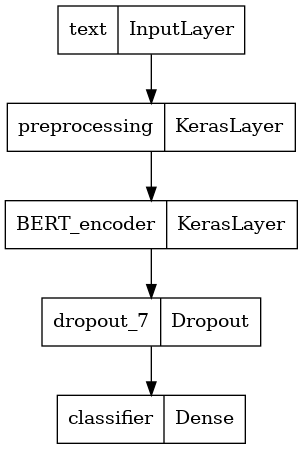

In [104]:
tf.keras.utils.plot_model(classifierModel)

### Defining our loss function for binary classification

In [105]:
# loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# metrics = tf.metrics.BinaryAccuracy()

loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.metrics.CategoricalAccuracy(name="accuracy")


### Defining our optimizer

In [106]:
trainTextsVariable = tf.Variable(trainTexts)
testTextsVariable = tf.Variable(testTexts)

trainDataset = tf.data.Dataset.from_tensor_slices((trainTexts, trainLabels)).batch(32)
testDataset = tf.data.Dataset.from_tensor_slices((testTexts, testLabels)).batch(32)

# list(trainDataset.as_numpy_iterator())

for text_batch in trainDataset.take(100):
  # for i in range(2):
  print(f'Review: ', text_batch)
  # label = label_batch.numpy()
  # print(f'Label : {label} ({trainLabels[label]})')


Review:  (<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b"I'll live my life the way I want bitch",
       b"Don't fw sloppy hoes, You might catch somethin..",
       b'Dead af, stupid bitches still talking shit &#128514;',
       b'@vhr6190 @NudesForJordy playoffs bitch',
       b'@SideHoeNextDoor with your height, yeah. Chunky bitch',
       b'@CapoDaAssHole lol that hoe for 5yr old',
       b'@hxhsharingan666 did you make an animal cracker taco',
       b'Fight me den hoe',
       b'@SammyLightning_ I roll up to a bitch an dey like http://t.co/ja8t60VgGE',
       b'Just got done taking some photos with brownie #flowcity',
       b'RT @SuziDodt: Science, bitch! #TheWalkingDead',
       b'top layer trash.',
       b'@bonnoxxx yea cuh a bitch fuc donald sterling .. Cuhz pimpin tho',
       b'RT @thaboyrich: &#128073;&#128073;RT @NYSAnimal It used to be a shame to be hoe/prostitute, with social media they call it hustling lol',
       b'RT @Julio_isUrdaddy: She need a man, not no 

In [107]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(trainDataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
#AdamW Optimizer is best for BERT (Initialy Adam was used with BERT)
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

print("Epochs: ", epochs)
print("Steps per Epoch: ", steps_per_epoch)
print("Number Train Steps: ", num_train_steps)
print("Number Warmup Steps: ", num_warmup_steps)

Epochs:  5
Steps per Epoch:  620
Number Train Steps:  3100
Number Warmup Steps:  310


### Compiling our Model using the Defined Loss and Optimizer

In [108]:
classifierModel.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# Training The Model

In [109]:
print("Training Model using {BERT_ENCODER_URL}")
trainingHistory = classifierModel.fit(trainDataset, validation_data=testDataset, epochs=epochs)


Training Model using {BERT_ENCODER_URL}
Epoch 1/5
  6/620 [..............................] - ETA: 32:43 - loss: 1.1616 - accuracy: 0.4167

KeyboardInterrupt: 

## Quickly test our Model predictions